In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [2]:
# 필요 라이브러리 import
import pandas as pd
import numpy as np
from datetime import timedelta

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import joblib # 인코더 저장용
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks   import EarlyStopping, ModelCheckpoint

from sklearn.metrics import recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [3]:
# 파라미터 튜닝
my_optimizer = Adam(learning_rate=0.01)
my_patience = 5
my_epochs = 100000
my_batch_size = 1024

# LSTM (Long Short-Term Memory)

시계열 데이터에서 과거 패턴을 학습해 미래를 예측

순서를 고려한 학습 (timesteps 필요)

입력은 3D 텐서 (samples, timesteps, features)

시간 간격 정보가 중요한 문제에 적합

# DNN (Deep Neural Network)

일반적인 피드포워드 신경망

순서를 고려하지 않음

모든 feature가 평평하게 주어질 때 효과적

비교적 빠르게 학습됨

# LightGBM
Microsoft가 개발한 Gradient Boosting Tree 기반의 알고리즘

범주형 변수, 결측치 처리에 강함

빠른 속도와 높은 성능

시계열 구조는 직접 반영되지 않지만, lag feature 활용으로 보완 가능

In [4]:
df = pd.read_csv('LSTM최종데이터_X_Y_라벨링등전.csv')
# # 결측 제거
# df = df.dropna(subset=['대여량'])

# 대여량을 범주형으로 변환
def label_rent(value):
    if value < 100: return 0
    elif value < 200: return 1
    elif value < 400: return 2
    elif value < 800: return 3
    elif value < 1600: return 4
    else: return 5

df['rent_class'] = df['대여량'].apply(label_rent)

# 필요 없는 열 제거
drop_cols = ['연도', '월', '일', '일시', '대여량']  # 원래 대여량 제거
df_model = df.drop(columns=drop_cols)

# 범주형 → 숫자 인코딩
categorical_cols = ['행정구', '계절', '출퇴근시간']
df_model[categorical_cols] = df_model[categorical_cols].apply(LabelEncoder().fit_transform)

# X, y 분리
X = df_model.drop(columns='rent_class')
y = df_model['rent_class']

# 스케일링 (DNN/LSTM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# DNN, LightGBM용 train/test
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LSTM용 reshape
timesteps = 1  # 시계열 길이 = 1 (각 row가 t 시점 데이터)
X_lstm = X_scaled.reshape((X_scaled.shape[0], timesteps, X_scaled.shape[1]))
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_lstm, y, test_size=0.2, random_state=42)

# 콜백함수 적용
es = EarlyStopping(patience=my_patience)
model_lstm_checkpoint = ModelCheckpoint('ver1_model/lstm_accuracy{val_accuracy}_loss{val_loss}',save_best_only=True)
model_dnn_checkpoint = ModelCheckpoint('ver1_model/dnn_accuracy{val_accuracy}_loss{val_loss}',save_best_only=True)

# LSTM

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')  # 6개 클래스
])
model_lstm.compile(optimizer=my_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# DNN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_flat.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
model_dnn.compile(optimizer=my_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# LightGBM

In [7]:
import lightgbm as lgb

model_lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=6, random_state=42)

In [8]:

# LSTM
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=my_epochs, batch_size=128, validation_split=0.2, verbose=1,
                             callbacks=[es,model_lstm_checkpoint])

# # DNN
history_dnn = model_dnn.fit(X_train_flat, y_train, epochs=my_epochs, batch_size=128, validation_split=0.2, verbose=1,
                           callbacks=[es,model_dnn_checkpoint])

# # LightGBM
model_lgbm.fit(X_train_flat, y_train)


Epoch 1/100000
4808/4814 [============================>.] - ETA: 0s - loss: 0.9227 - accuracy: 0.6072

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.644533634185791_loss0.8378322124481201\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.644533634185791_loss0.8378322124481201\assets


4814/4814 [==============================] - 19s 3ms/step - loss: 0.9226 - accuracy: 0.6072 - val_loss: 0.8378 - val_accuracy: 0.6445
Epoch 2/100000
4804/4814 [============================>.] - ETA: 0s - loss: 0.8083 - accuracy: 0.6584

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6647513508796692_loss0.7934332489967346\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6647513508796692_loss0.7934332489967346\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.8083 - accuracy: 0.6584 - val_loss: 0.7934 - val_accuracy: 0.6648
Epoch 3/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.7777 - accuracy: 0.6716

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.67169189453125_loss0.7760080099105835\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.67169189453125_loss0.7760080099105835\assets


4814/4814 [==============================] - 18s 4ms/step - loss: 0.7777 - accuracy: 0.6716 - val_loss: 0.7760 - val_accuracy: 0.6717
Epoch 4/100000
4795/4814 [============================>.] - ETA: 0s - loss: 0.7628 - accuracy: 0.6776

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6795348525047302_loss0.7569786906242371\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6795348525047302_loss0.7569786906242371\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7628 - accuracy: 0.6776 - val_loss: 0.7570 - val_accuracy: 0.6795
Epoch 5/100000
4801/4814 [============================>.] - ETA: 0s - loss: 0.7531 - accuracy: 0.6822

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6852743029594421_loss0.7506646513938904\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6852743029594421_loss0.7506646513938904\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7532 - accuracy: 0.6822 - val_loss: 0.7507 - val_accuracy: 0.6853
Epoch 6/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.7454 - accuracy: 0.6856

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6894944310188293_loss0.7391098141670227\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6894944310188293_loss0.7391098141670227\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7454 - accuracy: 0.6855 - val_loss: 0.7391 - val_accuracy: 0.6895
Epoch 7/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.7382 - accuracy: 0.6883

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6904163956642151_loss0.7335837483406067\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6904163956642151_loss0.7335837483406067\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7382 - accuracy: 0.6883 - val_loss: 0.7336 - val_accuracy: 0.6904
Epoch 8/100000
4805/4814 [============================>.] - ETA: 0s - loss: 0.7328 - accuracy: 0.6908

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6929029822349548_loss0.7317086458206177\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6929029822349548_loss0.7317086458206177\assets


4814/4814 [==============================] - 18s 4ms/step - loss: 0.7328 - accuracy: 0.6908 - val_loss: 0.7317 - val_accuracy: 0.6929
Epoch 9/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7291 - accuracy: 0.6919 - val_loss: 0.7403 - val_accuracy: 0.6870
Epoch 10/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7259 - accuracy: 0.6937 - val_loss: 0.7340 - val_accuracy: 0.6913
Epoch 11/100000
4803/4814 [============================>.] - ETA: 0s - loss: 0.7229 - accuracy: 0.6946

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6948702335357666_loss0.7238137722015381\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6948702335357666_loss0.7238137722015381\assets


4814/4814 [==============================] - 17s 3ms/step - loss: 0.7229 - accuracy: 0.6946 - val_loss: 0.7238 - val_accuracy: 0.6949
Epoch 12/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.7205 - accuracy: 0.6956

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6949287056922913_loss0.7227702736854553\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6949287056922913_loss0.7227702736854553\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7206 - accuracy: 0.6956 - val_loss: 0.7228 - val_accuracy: 0.6949
Epoch 13/100000
4813/4814 [============================>.] - ETA: 0s - loss: 0.7179 - accuracy: 0.6973

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6938379406929016_loss0.7225635051727295\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6938379406929016_loss0.7225635051727295\assets


4814/4814 [==============================] - 18s 4ms/step - loss: 0.7179 - accuracy: 0.6973 - val_loss: 0.7226 - val_accuracy: 0.6938
Epoch 14/100000
4809/4814 [============================>.] - ETA: 0s - loss: 0.7154 - accuracy: 0.6976

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6981814503669739_loss0.7161579132080078\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6981814503669739_loss0.7161579132080078\assets


4814/4814 [==============================] - 18s 4ms/step - loss: 0.7154 - accuracy: 0.6977 - val_loss: 0.7162 - val_accuracy: 0.6982
Epoch 15/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.7132 - accuracy: 0.6990

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.696772575378418_loss0.7155903577804565\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.696772575378418_loss0.7155903577804565\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7133 - accuracy: 0.6990 - val_loss: 0.7156 - val_accuracy: 0.6968
Epoch 16/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7121 - accuracy: 0.6991 - val_loss: 0.7231 - val_accuracy: 0.6961
Epoch 17/100000
4804/4814 [============================>.] - ETA: 0s - loss: 0.7100 - accuracy: 0.7001

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6995578408241272_loss0.7144275903701782\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.6995578408241272_loss0.7144275903701782\assets


4814/4814 [==============================] - 17s 3ms/step - loss: 0.7101 - accuracy: 0.7001 - val_loss: 0.7144 - val_accuracy: 0.6996
Epoch 18/100000
4814/4814 [==============================] - 16s 3ms/step - loss: 0.7085 - accuracy: 0.7006 - val_loss: 0.7231 - val_accuracy: 0.6945
Epoch 19/100000
4803/4814 [============================>.] - ETA: 0s - loss: 0.7071 - accuracy: 0.7008

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7052388191223145_loss0.7038297057151794\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7052388191223145_loss0.7038297057151794\assets


4814/4814 [==============================] - 19s 4ms/step - loss: 0.7071 - accuracy: 0.7008 - val_loss: 0.7038 - val_accuracy: 0.7052
Epoch 20/100000
4814/4814 [==============================] - 16s 3ms/step - loss: 0.7055 - accuracy: 0.7014 - val_loss: 0.7168 - val_accuracy: 0.6970
Epoch 21/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7043 - accuracy: 0.7015 - val_loss: 0.7055 - val_accuracy: 0.7010
Epoch 22/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7024 - accuracy: 0.7024 - val_loss: 0.7108 - val_accuracy: 0.7009
Epoch 23/100000
4809/4814 [============================>.] - ETA: 0s - loss: 0.7014 - accuracy: 0.7034

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7056608200073242_loss0.7000747919082642\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7056608200073242_loss0.7000747919082642\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.7014 - accuracy: 0.7035 - val_loss: 0.7001 - val_accuracy: 0.7057
Epoch 24/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.7000 - accuracy: 0.7037 - val_loss: 0.7037 - val_accuracy: 0.7015
Epoch 25/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6994 - accuracy: 0.7040 - val_loss: 0.7140 - val_accuracy: 0.6990
Epoch 26/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6983 - accuracy: 0.7050 - val_loss: 0.7016 - val_accuracy: 0.7041
Epoch 27/100000
4810/4814 [============================>.] - ETA: 0s - loss: 0.6976 - accuracy: 0.7053

INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7063230872154236_loss0.69852215051651\assets


INFO:tensorflow:Assets written to: ver1_model\lstm_accuracy0.7063230872154236_loss0.69852215051651\assets


4814/4814 [==============================] - 17s 4ms/step - loss: 0.6975 - accuracy: 0.7053 - val_loss: 0.6985 - val_accuracy: 0.7063
Epoch 28/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6971 - accuracy: 0.7055 - val_loss: 0.7018 - val_accuracy: 0.7046
Epoch 29/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6969 - accuracy: 0.7059 - val_loss: 0.7033 - val_accuracy: 0.7056
Epoch 30/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6957 - accuracy: 0.7063 - val_loss: 0.7047 - val_accuracy: 0.7036
Epoch 31/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6951 - accuracy: 0.7061 - val_loss: 0.7126 - val_accuracy: 0.6976
Epoch 32/100000
4814/4814 [==============================] - 15s 3ms/step - loss: 0.6949 - accuracy: 0.7067 - val_loss: 0.7030 - val_accuracy: 0.7059
Epoch 1/100000
4804/4814 [============================>.] - ETA: 0s - loss: 1.0602 - accuracy: 0.5518INFO:tensorflow

INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.5777838230133057_loss0.9881194829940796\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 1.0601 - accuracy: 0.5518 - val_loss: 0.9881 - val_accuracy: 0.5778
Epoch 2/100000
4808/4814 [============================>.] - ETA: 0s - loss: 1.0141 - accuracy: 0.5668INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.5877044200897217_loss0.9683213829994202\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.5877044200897217_loss0.9683213829994202\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 1.0141 - accuracy: 0.5668 - val_loss: 0.9683 - val_accuracy: 0.5877
Epoch 3/100000
4791/4814 [============================>.] - ETA: 0s - loss: 0.9982 - accuracy: 0.5740INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.5971900224685669_loss0.9392558336257935\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.5971900224685669_loss0.9392558336257935\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9981 - accuracy: 0.5740 - val_loss: 0.9393 - val_accuracy: 0.5972
Epoch 4/100000
4786/4814 [============================>.] - ETA: 0s - loss: 0.9791 - accuracy: 0.5834INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6035526990890503_loss0.9307987689971924\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6035526990890503_loss0.9307987689971924\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 0.9791 - accuracy: 0.5834 - val_loss: 0.9308 - val_accuracy: 0.6036
Epoch 5/100000
4802/4814 [============================>.] - ETA: 0s - loss: 0.9705 - accuracy: 0.5883INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.604169487953186_loss0.9229382276535034\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.604169487953186_loss0.9229382276535034\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9705 - accuracy: 0.5883 - val_loss: 0.9229 - val_accuracy: 0.6042
Epoch 6/100000
4808/4814 [============================>.] - ETA: 0s - loss: 0.9654 - accuracy: 0.5905INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.608266294002533_loss0.9169731140136719\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.608266294002533_loss0.9169731140136719\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 0.9654 - accuracy: 0.5905 - val_loss: 0.9170 - val_accuracy: 0.6083
Epoch 7/100000
4802/4814 [============================>.] - ETA: 0s - loss: 0.9628 - accuracy: 0.5913INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6070067286491394_loss0.915817141532898\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6070067286491394_loss0.915817141532898\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9627 - accuracy: 0.5913 - val_loss: 0.9158 - val_accuracy: 0.6070
Epoch 8/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.9610 - accuracy: 0.5923INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6096556782722473_loss0.9157711267471313\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6096556782722473_loss0.9157711267471313\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9610 - accuracy: 0.5923 - val_loss: 0.9158 - val_accuracy: 0.6097
Epoch 9/100000
4812/4814 [============================>.] - ETA: 0s - loss: 0.9605 - accuracy: 0.5931INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6078637838363647_loss0.9146209955215454\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6078637838363647_loss0.9146209955215454\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9605 - accuracy: 0.5931 - val_loss: 0.9146 - val_accuracy: 0.6079
Epoch 10/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9597 - accuracy: 0.5924 - val_loss: 0.9159 - val_accuracy: 0.6011
Epoch 11/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9576 - accuracy: 0.5940 - val_loss: 0.9258 - val_accuracy: 0.6044
Epoch 12/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9556 - accuracy: 0.5949 - val_loss: 0.9321 - val_accuracy: 0.6048
Epoch 13/100000
4808/4814 [============================>.] - ETA: 0s - loss: 0.9541 - accuracy: 0.5952INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6160184144973755_loss0.9054508209228516\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6160184144973755_loss0.9054508209228516\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9541 - accuracy: 0.5952 - val_loss: 0.9055 - val_accuracy: 0.6160
Epoch 14/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9520 - accuracy: 0.5972 - val_loss: 0.9076 - val_accuracy: 0.6148
Epoch 15/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9507 - accuracy: 0.5978 - val_loss: 0.9076 - val_accuracy: 0.6192
Epoch 16/100000
4788/4814 [============================>.] - ETA: 0s - loss: 0.9506 - accuracy: 0.5974INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6134408712387085_loss0.9039753675460815\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6134408712387085_loss0.9039753675460815\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 0.9505 - accuracy: 0.5975 - val_loss: 0.9040 - val_accuracy: 0.6134
Epoch 17/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9491 - accuracy: 0.5987 - val_loss: 0.9044 - val_accuracy: 0.6085
Epoch 18/100000
4807/4814 [============================>.] - ETA: 0s - loss: 0.9499 - accuracy: 0.5981INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6187776923179626_loss0.8969689011573792\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6187776923179626_loss0.8969689011573792\assets


4814/4814 [==============================] - 11s 2ms/step - loss: 0.9499 - accuracy: 0.5981 - val_loss: 0.8970 - val_accuracy: 0.6188
Epoch 19/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9490 - accuracy: 0.5982 - val_loss: 0.9090 - val_accuracy: 0.6116
Epoch 20/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9487 - accuracy: 0.5989 - val_loss: 0.9049 - val_accuracy: 0.6190
Epoch 21/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9493 - accuracy: 0.5977 - val_loss: 0.9081 - val_accuracy: 0.6059
Epoch 22/100000
4800/4814 [============================>.] - ETA: 0s - loss: 0.9490 - accuracy: 0.5989INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6183362007141113_loss0.8938277363777161\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6183362007141113_loss0.8938277363777161\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 0.9489 - accuracy: 0.5989 - val_loss: 0.8938 - val_accuracy: 0.6183
Epoch 23/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9465 - accuracy: 0.5999 - val_loss: 0.8962 - val_accuracy: 0.6223
Epoch 24/100000
4800/4814 [============================>.] - ETA: 0s - loss: 0.9448 - accuracy: 0.6013INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6196022629737854_loss0.892235279083252\assets


INFO:tensorflow:Assets written to: ver1_model\dnn_accuracy0.6196022629737854_loss0.892235279083252\assets


4814/4814 [==============================] - 10s 2ms/step - loss: 0.9449 - accuracy: 0.6013 - val_loss: 0.8922 - val_accuracy: 0.6196
Epoch 25/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9442 - accuracy: 0.6014 - val_loss: 0.9015 - val_accuracy: 0.6179
Epoch 26/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9431 - accuracy: 0.6015 - val_loss: 0.8957 - val_accuracy: 0.6172
Epoch 27/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9454 - accuracy: 0.6009 - val_loss: 0.8999 - val_accuracy: 0.6219
Epoch 28/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9432 - accuracy: 0.6018 - val_loss: 0.8989 - val_accuracy: 0.6207
Epoch 29/100000
4814/4814 [==============================] - 10s 2ms/step - loss: 0.9431 - accuracy: 0.6015 - val_loss: 0.9070 - val_accuracy: 0.6159
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013229 seconds.
You can set 

LGBMClassifier(num_class=6, objective='multiclass', random_state=42)

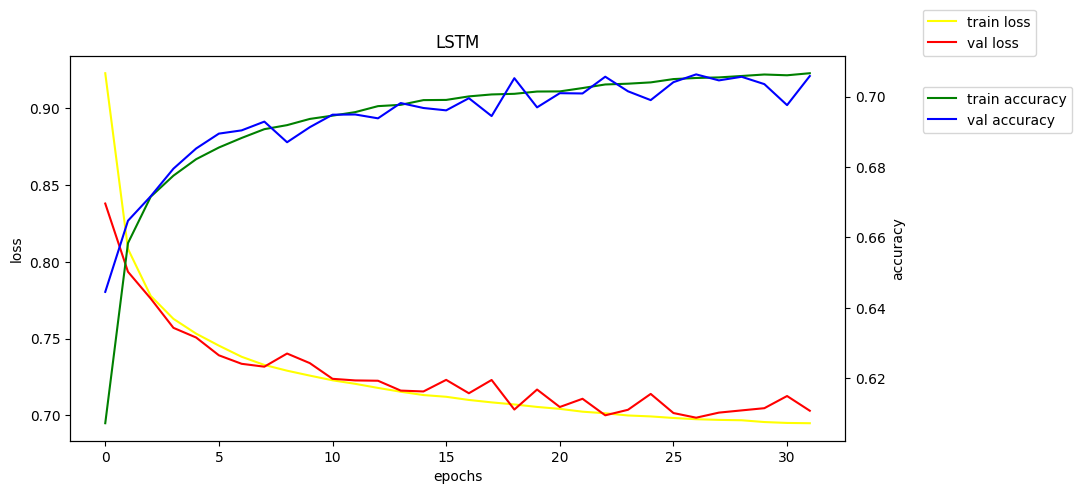

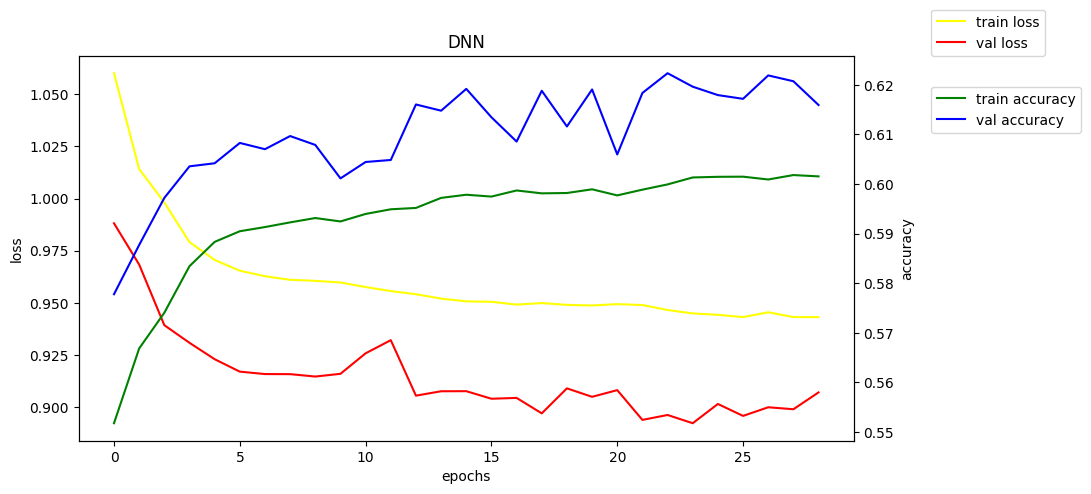

In [9]:
import matplotlib.pyplot as plt

def plot_history(history, title='Model'):
    fig, loss_ax = plt.subplots(figsize = (10,5))
    loss_ax.plot(history.history.get('loss'), color='yellow', label='train loss')
    loss_ax.plot(history.history.get('val_loss'), color='red', label='val loss')
    loss_ax.legend(loc=(1.1,1))
    loss_ax.set_xlabel('epochs')
    loss_ax.set_ylabel('loss')
    acc_ax = loss_ax.twinx()
    acc_ax.plot(history.history.get('accuracy'), color='green', label='train accuracy')
    acc_ax.plot(history.history.get('val_accuracy'), color='blue', label='val accuracy')
    acc_ax.legend(loc=(1.1,0.8))
    acc_ax.set_ylabel('accuracy')
    plt.title(title)
    plt.show()

plot_history(history_lstm, 'LSTM')
plot_history(history_dnn, 'DNN')

In [10]:
from sklearn.metrics import classification_report

# LSTM
y_pred_lstm = np.argmax(model_lstm.predict(X_test_seq), axis=1)
print("LSTM:\n", classification_report(y_test_seq, y_pred_lstm))

# DNN
y_pred_dnn = np.argmax(model_dnn.predict(X_test_flat), axis=1)
print("DNN:\n", classification_report(y_test, y_pred_dnn))

# LightGBM
y_pred_lgbm = model_lgbm.predict(X_test_flat)
print("LightGBM:\n", classification_report(y_test, y_pred_lgbm))


6017/6017 [==============================] - 6s 987us/step
LSTM:
               precision    recall  f1-score   support

           0       0.82      0.86      0.83     81425
           1       0.61      0.62      0.61     40700
           2       0.62      0.71      0.66     33453
           3       0.67      0.61      0.64     14941
           4       0.58      0.69      0.63      3500
           5       0.60      0.31      0.41     18510

    accuracy                           0.71    192529
   macro avg       0.65      0.63      0.63    192529
weighted avg       0.70      0.71      0.70    192529

6017/6017 [==============================] - 4s 644us/step
DNN:
               precision    recall  f1-score   support

           0       0.76      0.80      0.78     81425
           1       0.48      0.61      0.54     40700
           2       0.52      0.62      0.57     33453
           3       0.53      0.48      0.50     14941
           4       0.47      0.15      0.23      3500
 

In [11]:
print('LSTM :')
display(pd.crosstab(y_test_seq,y_pred_lstm,rownames=['실제값'],colnames=['예측값']))
print('DNN :')
display(pd.crosstab(y_test_seq,y_pred_dnn,rownames=['실제값'],colnames=['예측값']))
print('LightGBM :')
display(pd.crosstab(y_test_seq,y_pred_lgbm,rownames=['실제값'],colnames=['예측값']))

LSTM :


예측값,0,1,2,3,4,5
실제값,,,,,,
0,69639,7860,2024,415,76,1411
1,7864,25260,6383,285,40,868
2,990,5422,23805,2481,111,644
3,279,43,3864,9040,1181,534
4,29,0,22,681,2414,354
5,6629,2862,2338,597,328,5756


DNN :


예측값,0,1,2,3,4,5
실제값,,,,,,
0,65427,13382,2188,331,24,73
1,8406,24825,7061,295,16,97
2,1569,8965,20671,2137,40,71
3,329,380,6876,7150,121,85
4,62,10,143,2687,524,74
5,10019,4301,2630,993,386,181


LightGBM :


예측값,0,1,2,3,4,5
실제값,,,,,,
0,71339,6521,2140,607,99,719
1,9556,23398,6513,395,56,782
2,1378,5443,23109,2989,82,452
3,213,62,3579,10189,768,130
4,7,0,25,1148,2241,79
5,7750,2782,2446,904,520,4108


In [12]:
# 예시: 2025년 어느 날, 특정 행정구의 feature 벡터 (scaler 적용 필요)
# input_data: shape = (1, feature_dim)

# 전처리 → 예측
input_scaled = scaler.transform(input_data)

# LSTM
input_seq = input_scaled.reshape((1, 1, input_scaled.shape[1]))
pred_lstm = np.argmax(model_lstm.predict(input_seq))

# DNN
pred_dnn = np.argmax(model_dnn.predict(input_scaled))

# LightGBM
pred_lgbm = model_lgbm.predict(input_scaled)[0]

print(f"LSTM 예측: {pred_lstm} / DNN 예측: {pred_dnn} / LightGBM 예측: {pred_lgbm}")


NameError: name 'input_data' is not defined